[Link for description of dataset](https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition)<br>
[Research paper](http://users.fs.cvut.cz/ivo.bukovsky/PROJEKT/Data/Realna/BIO/EEG/reference/PRE61907.pdf)<br>
[Kaggle](https://www.kaggle.com/harunshimanto/epileptic-seizure-recognition)

Electroencephalography (EEG) is an electrophysiological monitoring method to record electrical activity of the brain.

### Short description of dataset

|Data Set Characteristics||Attribute Characteristics||Associated Tasks||Number of Instances||Number of Attributes||Missing Values?|
|---||---||---||---||---||---|
|Multivariate, Time-Series||Integer, Real||Classification, Clustering||11500||179||N/A|



### Plan
    - Change the y target column (make a binary classification task)
    - Remove Unnamed: 0 column (additionaly check the importance of it)
    - EDA + Smart visualisation of data
    - Make pipelines for all the approaches for binary classification task + make a comperison table of results
    ----------------
    - PCA or ICA (from mne) --> reduce size of data
    - Use previous pipelines for reduced data + make a comperison table of results
    - Model tuning???
    

### Imports

In [367]:
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

import plotly
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import init_notebook_mode, iplot


import seaborn as sns

init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 100)

In [23]:
#Read data directly from web application (additionally we can download data locally)
#Further we will dowload additional data (extended option for training)

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00388/data.csv')

In [4]:
#Let us have a quick look on a data

In [5]:
data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [6]:
#We observe weird names of features (we have 180 different features).
#Let us look throught description of features and target (y) feature also.

We divided and shuffled every 4097 data points into 23 chunks, each chunk contains 178 data points for 1 second, and each data point is the value of the EEG recording at a different point in time.<br>
So now we have 23 x 500 = 11500 pieces of information(row), each information contains 178 data points for 1 second(column), the last column represents the label y {1,2,3,4,5}. 


In [17]:
11500 / 500

23.0

In [18]:
#So, we have in total 11500 records(rows).
#Each 23(1 chunk) rows represent record for 1 second.(It means if we would like to plot data for second, we need 23 rows for that).

#We can calculate how much seconds(minutes) we have in our data.
#For that we need: 11500(all rows) / 23(1 chunk(1 second)) = 500 (seconds)(500 / 60 = 8.3 minutes)
#We got 500 seconds. We can check correctness: 500 * 23 = 11500 records(rows)

#As well, we know, that in one row we have 

In [19]:
# from mne.datasets import sample

# #sample
# data_path = sample.data_path()
# data_path

# raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

# raw = mne.io.Raw(raw_fname, preload=False)
# print(raw)

# print(raw.ch_names[:10])

In [20]:
data.query('X1 > X2')

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
5,X14.V1.56,55,28,18,16,16,19,25,40,52,...,-12,-31,-42,-54,-60,-64,-60,-56,-55,5
7,X11.V1.273,1,-2,-8,-11,-12,-17,-15,-16,-18,...,-79,-91,-97,-88,-76,-72,-66,-57,-39,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11489,X7.V1.51,90,83,69,41,31,40,58,75,82,...,83,77,52,19,-20,-33,-18,9,30,5
11490,X14.V1.404,-22,-64,-121,-201,-292,-336,-398,-527,-773,...,183,-152,-499,-577,-415,-223,-88,-18,-61,1
11492,X13.V1.624,-27,-53,-84,-104,-131,-171,-199,-203,-177,...,-127,-114,-99,-79,-56,-28,-14,-8,-12,1
11493,X23.V1.714,-136,-137,-138,-135,-130,-123,-116,-118,-119,...,-1,3,5,8,13,16,24,34,42,2


Each row represents just 1 second(not current person. It is just part of recordings). 
23 row represents full pictured recording (4096 data points = 178 (number of dimensions) * 23 seconds (rows)) --> and we can observe recordings of EEG for one person. 

In our case we have 500 individual persons. (500 records. But they are shuffled, so cann't find initial structure. 
It means we can use our data just the following way: 1 row - 1 second - 1 prediction)

Regarding y column (target column) we have descriptions: 

y contains the category of the 178-dimensional input vector. 
Specifically y in {1, 2, 3, 4, 5}: 
 - 5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open 

 - 4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed 

 - 3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area 

 - 2 - They recorder the EEG from the area where the tumor was located 

 - 1 - Recording of seizure activity 

All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have epileptic seizure. Our motivation for creating this version of the data was to simplify access to the data via the creation of a .csv version of it. Although there are 5 classes most authors have done binary classification, namely class 1 (Epileptic seizure) against the rest.

In [21]:
#Balanced
data.y.value_counts()

5    2300
4    2300
3    2300
2    2300
1    2300
Name: y, dtype: int64

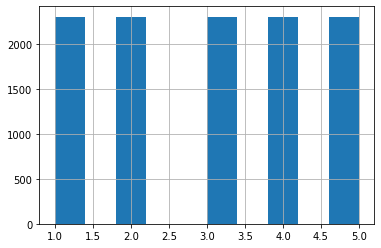

In [23]:
data.y.hist();

In [7]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(50,4))
# plt.subplot(131)
# [plt.plot(data.values[i][1:-1]) for i in range(len(data))];

### Change the y target column (make a binary classification task)

In [24]:
dic = {5: 0, 4: 0, 3: 0, 2: 0, 1: 1}
data['y'] = data['y'].map(dic)

In [25]:
data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [26]:
data['y'].value_counts()

0    9200
1    2300
Name: y, dtype: int64

### Remove Unnamed: 0 column (additionaly check the importance of it)

In [30]:
data = data.drop('Unnamed: 0', axis = 1)

In [31]:
data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,-22,-22,-23,-26,-36,-42,-45,-42,-45,-49,...,15,16,12,5,-1,-18,-37,-47,-48,0
11496,-47,-11,28,77,141,211,246,240,193,136,...,-65,-33,-7,14,27,48,77,117,170,1
11497,14,6,-13,-16,10,26,27,-9,4,14,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,0
11498,-40,-25,-9,-12,-2,12,7,19,22,29,...,121,135,148,143,116,86,68,59,55,0


0    80.28169
1    19.71831
Name: y, dtype: float64 %


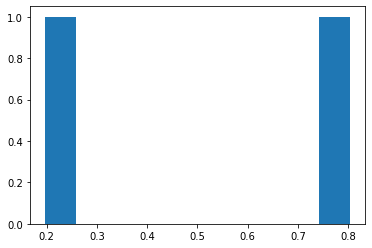

In [52]:
#Here we can observe that in first part of data (5750 values) we have unbalanced situation with target
print(data[:5751]['y'].value_counts(normalize=True) * 100, '%')
plt.hist(data[:5751]['y'].value_counts(normalize=True));

0    79.718212
1    20.281788
Name: y, dtype: float64


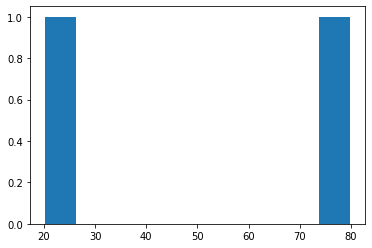

In [53]:
#Let's check for second part (another rest of data). Alsmost the same situation
print(data[5751:]['y'].value_counts(normalize=True) * 100)
plt.hist(data[5751:]['y'].value_counts(normalize=True) * 100);

### Shuffle data because of previous manipulations

In [58]:
from sklearn.utils import shuffle

data = shuffle(data)

In [59]:
data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
2933,-28,-44,-63,-85,-94,-101,-109,-111,-109,-105,...,-118,-123,-130,-137,-146,-150,-153,-150,-147,0
2075,-199,-207,-187,-145,-126,-80,-30,35,69,65,...,-291,43,414,691,866,919,877,772,640,1
10427,-10,-20,-20,-3,4,8,26,36,50,45,...,11,3,-4,-5,-4,-2,-11,-7,-12,0
9027,-3,6,41,54,53,49,46,37,20,-1,...,-5,-7,-26,-58,-66,-37,-11,22,56,0
7850,40,60,74,70,67,48,44,44,52,69,...,58,47,12,-16,-35,-24,-11,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5831,-42,-51,-51,-54,-57,-58,-62,-63,-59,-54,...,-12,-12,-7,-3,2,-3,-7,-5,0,0
5536,-10,-36,-40,-52,-32,-32,-29,-39,-51,-45,...,-31,-13,-4,-8,-4,11,34,57,75,0
5625,-25,-29,-31,-32,-37,-35,-30,-27,-22,-19,...,-33,-39,-49,-64,-87,-101,-110,-111,-111,0
3586,-114,-135,-157,-179,-206,-233,-263,-289,-301,-298,...,-313,-385,-375,-306,-225,-163,-112,-71,-25,1


In [60]:
#Here we can observe that in first part of data (5750 values) we have unbalanced situation with target
print(data[:5751]['y'].value_counts(normalize=True) * 100)
print(data[5751:]['y'].value_counts(normalize=True) * 100)

0    80.264302
1    19.735698
Name: y, dtype: float64
0    79.735606
1    20.264394
Name: y, dtype: float64


### EDA + Smart visualisation of data

In [80]:
data['y'].iplot(
    kind='hist',
    bins=100,
    xTitle='price',
    linecolor='black',
    yTitle='count',
    title='Histogram of y target')

In [83]:
table_cat = ff.create_table(data.describe().T, index=True, index_title='Signals')
iplot(table_cat)

### Let us have a look on EPILIPTIC AND NON EPILETTIC CASES

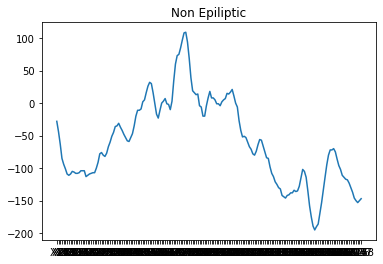

In [102]:
#Non Epileptic
plt.plot(data.iloc[0][0:-1]);
plt.title('Non Epiliptic');

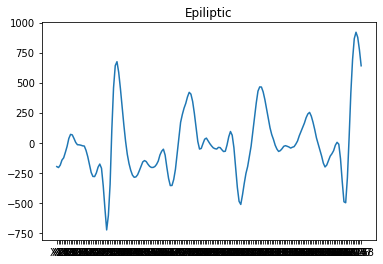

In [101]:
#Epileptic
plt.plot(data.iloc[1][0:-1]);
plt.title('Epiliptic');

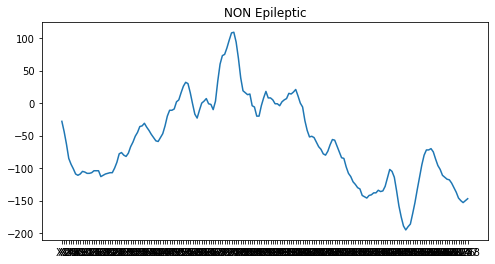

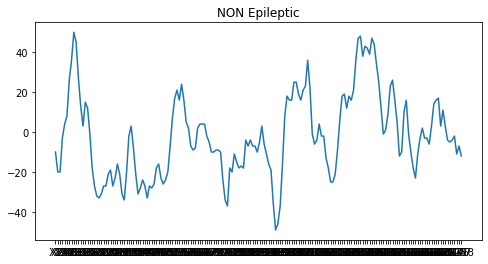

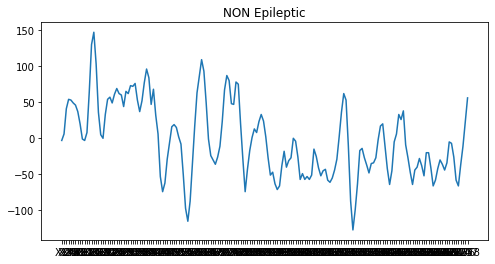

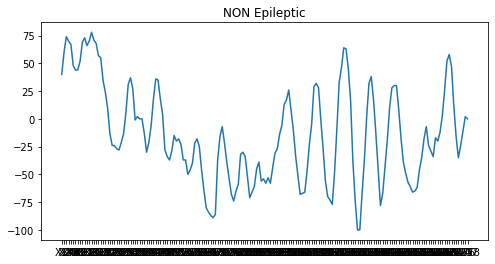

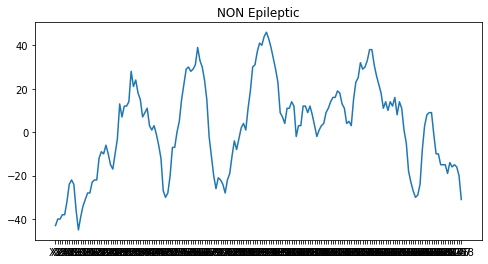

In [121]:
#Few more cases of NON Epileptic
[(plt.figure(figsize=(8,4)), plt.title('NON Epileptic'), plt.plot(data[data['y'] == 0].iloc[i][0:-1])) for i in range(5)];

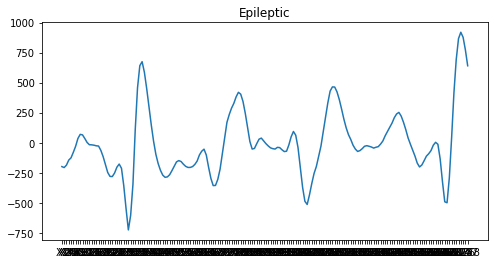

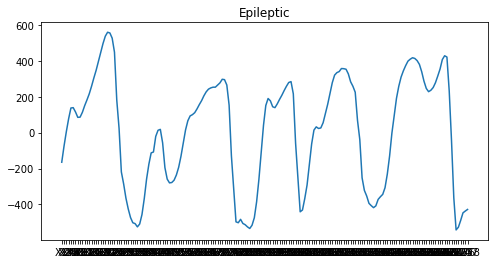

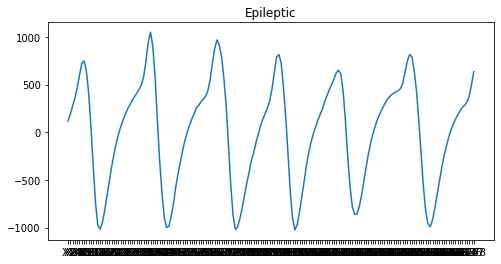

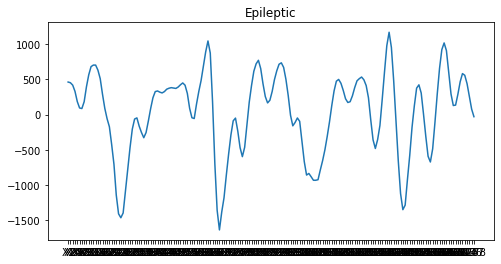

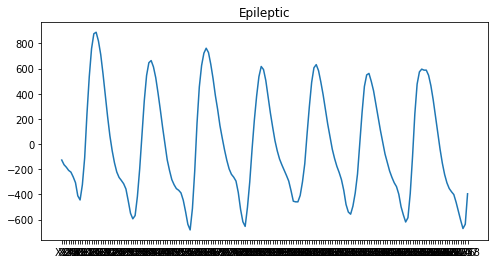

In [122]:
#Few more cases of Epileptic
[(plt.figure(figsize=(8,4)), plt.title('Epileptic'), plt.plot(data[data['y'] == 1].iloc[i][0:-1])) for i in range(5)];

So, as we can observe, reords of Epileptic seusizes are more smooth and looks like have a tendency.

#### Despite previous plottings, let us try to make a statistical analysis of Epiliptic and NON Epileptic occureses. 

In [128]:
#Let us group all the Epileptic occureses and Non Epileptic

print('Number of records of Non Epileptic {0} VS Epilepttic {1}'.format(len(data[data['y'] == 0]), len(data[data['y'] == 1])))

Number of records of Non Epileptic 9200 VS Epilepttic 2300


In [131]:
#Description of Non Epileptic

data[data['y'] == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
X1,9200.0,-8.992609,70.455286,-566.0,-44.0,-7.0,26.0,1726.0
X2,9200.0,-8.877174,70.560110,-609.0,-44.0,-7.0,27.0,1713.0
X3,9200.0,-8.910435,70.372582,-594.0,-45.0,-7.0,28.0,1697.0
X4,9200.0,-8.969783,70.030409,-549.0,-45.0,-8.0,27.0,1612.0
X5,9200.0,-9.085326,69.377958,-603.0,-45.0,-8.0,27.0,1437.0
...,...,...,...,...,...,...,...,...
X175,9200.0,-9.848587,69.550894,-570.0,-45.0,-9.0,27.0,1958.0
X176,9200.0,-9.620435,70.353607,-594.0,-46.0,-8.0,27.0,2047.0
X177,9200.0,-9.395435,70.934300,-563.0,-45.0,-9.0,27.0,2047.0
X178,9200.0,-9.240435,71.185850,-559.0,-45.0,-8.0,27.0,1915.0


In [132]:
#Description of Epileptic

data[data['y'] == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
X1,2300.0,-21.936522,342.361939,-1839.0,-193.25,-16.0,159.00,1314.0
X2,2300.0,-19.049130,343.398782,-1838.0,-191.25,-18.0,168.25,1356.0
X3,2300.0,-15.293913,337.489643,-1835.0,-187.00,-12.5,169.25,1274.0
X4,2300.0,-9.836087,332.354833,-1845.0,-184.00,-6.0,166.25,1226.0
X5,2300.0,-3.707391,332.211163,-1791.0,-174.25,-12.0,170.00,1518.0
...,...,...,...,...,...,...,...,...
X175,2300.0,-25.830870,339.650467,-1863.0,-195.00,-14.5,153.25,1205.0
X176,2300.0,-25.043913,335.747017,-1781.0,-192.00,-18.0,150.00,1371.0
X177,2300.0,-24.548261,335.244512,-1727.0,-190.25,-21.5,151.25,1445.0
X178,2300.0,-24.016522,339.819309,-1829.0,-189.00,-23.0,157.25,1380.0


In [140]:
print('Totall Mean VALUE for Epiletic: {}'.format((data[data['y'] == 1].describe().mean()).mean()))
print('Totall Std VALUE for Epiletic: {}'.format((data[data['y'] == 1].describe().std()).std()))

Totall Mean VALUE for Epiletic: 290.129360958884
Totall Std VALUE for Epiletic: 53.56315864740058


In [141]:
print('Totall Mean VALUE for NON Epiletic: {}'.format((data[data['y'] == 0].describe().mean()).mean()))
print('Totall Std VALUE for NON Epiletic: {}'.format((data[data['y'] == 0].describe().std()).std()))

Totall Mean VALUE for NON Epiletic: 1260.098927262616
Totall Std VALUE for NON Epiletic: 15.561044289100957


In [183]:
data[data['y']==0].iloc[0:51][0:-1].values.shape
data[data['y']==1].iloc[0:51][0:-1].values.shape

(50, 179)

In [197]:
#Let us make a scatter plot of values for Epiletpic and Non Epileptic occureses

#plt.scatter(y=data[data['y']==0].iloc[0:51][0:-1].values, x=len(data[data['y']==0].iloc[0:51][0:-1].values));

In [217]:
len(data[data['y']==0])

9200

In [222]:
#.iloc(<range for rows>, <range for columns>)



[array([ -28,  -44,  -63,  -85,  -94, -101, -109, -111, -109, -105, -106,
        -108, -108, -107, -104, -104, -104, -113, -111, -109, -108, -107,
        -107, -100,  -91,  -78,  -76,  -80,  -82,  -77,  -67,  -60,  -51,
         -45,  -36,  -35,  -31,  -37,  -42,  -48,  -53,  -58,  -59,  -53,
         -47,  -35,  -20,  -11,  -11,   -9,    2,    5,   16,   26,   32,
          30,   16,   -1,  -17,  -23,  -11,    0,    3,    7,   -1,   -2,
         -10,    3,   34,   60,   73,   75,   85,   97,  108,  109,   94,
          69,   39,   19,   16,   13,   14,   -4,   -6,  -20,  -20,   -4,
           8,   18,    8,    8,    5,   -1,   -1,   -4,    2,    5,    7,
          15,   14,   17,   21,   11,    0,   -6,  -27,  -42,  -52,  -51,
         -53,  -60,  -67,  -71,  -78,  -80,  -74,  -64,  -56,  -57,  -66,
         -75,  -84,  -85,  -98, -108, -113, -121, -125, -130, -132, -142,
        -144, -146, -142, -141, -138, -138, -134, -136, -135, -128, -115,
        -102, -105, -114, -135, -158, 

In [231]:
[data[data['y']==0].iloc[:, range(0, len(data.columns)-1)].values][0]

np.max([data[data['y']==0].iloc[:, range(0, len(data.columns)-1)].values][0], axis=1)

array([109,  50, 147, ..., 288,  11, 104])

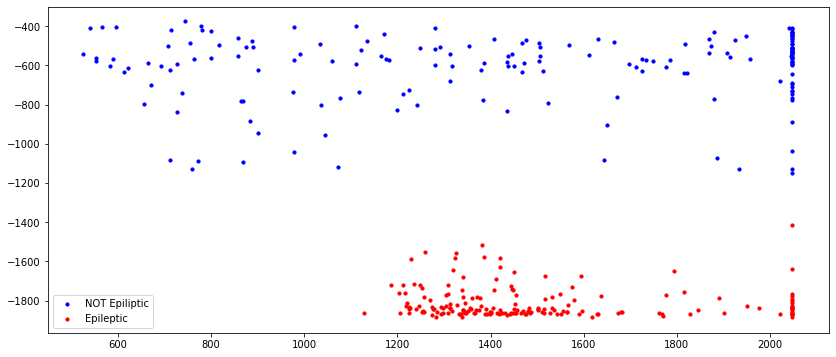

In [346]:
#lists of arrays containing all data
test1 = [data[data['y']==0].iloc[:, range(0, len(data.columns)-1)].values]
test2 = [data[data['y']==1].iloc[:, range(0, len(data.columns)-1)].values]

#calculate 2d indicators
def indic(test):
    max = np.max(test, axis=1)
    min = np.min(test, axis=1)
    return max, min

x1,y1 = indic(test1)
x2,y2 = indic(test2)


fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(111)

ax1.scatter(x1, y1, s=10, c='b', label='NOT Epiliptic')
ax1.scatter(x2, y2, s=10, c='r', label='Epileptic')
plt.legend(loc='lower left');
plt.show()

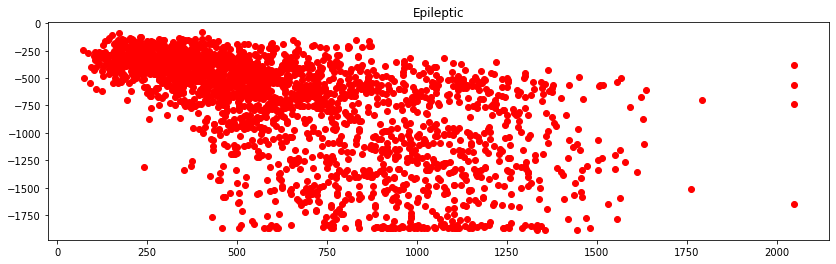

In [340]:
#Just Epileptic
x,y = indic(data[data['y']==1].iloc[:, range(0, len(data.columns)-1)].values)
plt.figure(figsize=(14,4))
plt.title('Epileptic')
plt.scatter(x, y, c='r');

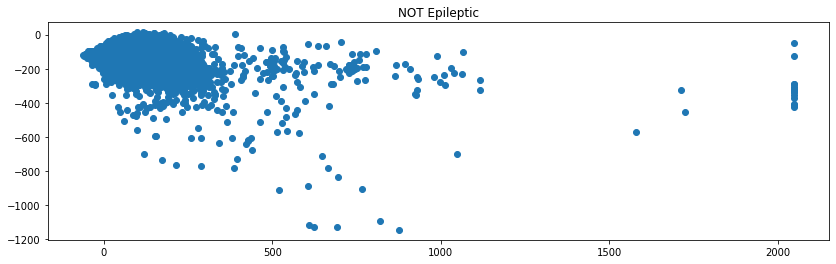

In [284]:
#Just NON Epileptic
x,y = indic(data[data['y']==0].iloc[:, range(0, len(data.columns)-1)].values)
plt.figure(figsize=(14,4))
plt.title('NOT Epileptic')
plt.scatter(x, y);

In [348]:
data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,...,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
count,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.00000,11500.00000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.00000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.00000,11500.000000,11500.000000,11500.000000,11500.000000,...,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000
mean,-11.581391,-10.911565,-10.187130,-9.143043,-8.009739,-7.003478,-6.502087,-6.68713,-6.55800,-6.168435,-5.827478,-6.042174,-6.687304,-7.088870,-7.211217,-7.088261,-6.806696,-6.744696,-6.484783,-6.448435,-6.355391,-6.543130,-6.884348,-6.883217,-6.118870,-5.15913,-4.785652,-4.874783,-5.393565,-5.935478,-6.349913,-6.212522,-5.859826,-5.299826,-4.955652,-5.278087,-6.162261,-7.316609,-7.998522,-7.818870,-6.964087,-5.773826,-4.700783,-4.143826,-4.546087,-5.53200,-6.670435,-7.702348,-7.894696,-8.081391,...,-7.629391,-7.373565,-7.439913,-7.592348,-6.897652,-6.000348,-5.423913,-5.151043,-5.586870,-6.281478,-6.997304,-7.339391,-7.911565,-8.177304,-8.608870,-8.578087,-8.240000,-7.691391,-7.356522,-7.228783,-6.980870,-6.756783,-6.355304,-6.423826,-6.465217,-6.316435,-5.808000,-5.255913,-4.682087,-4.638609,-4.770261,-5.650870,-7.170348,-8.759826,-9.784783,-10.096261,-9.842957,-9.701739,-9.351391,-9.498870,-10.145739,-11.630348,-12.943478,-13.668870,-13.363304,-13.045043,-12.705130,-12.426000,-12.195652,0.200000
std,165.626284,166.059609,163.524317,161.269041,160.998007,161.328725,161.467837,162.11912,162.03336,160.436352,160.471017,161.181118,165.071121,169.198359,170.641967,168.930355,164.646296,162.062661,162.571333,162.339911,162.823325,163.909723,165.844176,166.009100,164.715153,162.77423,162.902294,164.799831,165.391697,164.291120,163.165167,163.408052,163.561408,162.548119,160.813772,160.441049,162.881958,166.235164,166.314965,164.513017,161.197812,158.045513,157.490904,160.163082,163.996955,167.74431,171.232021,171.484787,169.299229,166.255922,...,158.301750,157.214361,158.679911,160.183325,162.002986,164.260512,166.182755,167.154785,167.414376,168.020316,168.567495,168.662705,167.643458,167.414439,167.922773,168.274009,167.808218,166.739558,165.678558,167.130911,168.156296,167.459868,165.061414,164.248830,166.226332,168.143625,167.067064,166.446540,167.554020,169.418457,170.639171,170.817824,168.145372,166.817974,166.999981,167.756860,166.988820,167.062497,166.606345,165.235574,164.652883,166.149790,168.554058,168.556486,167.257290,164.241019,162.895832,162.886311,164.852015,0.400017
min,-1839.000000,-1838.000000,-1835.000000,-1845.000000,-1791.000000,-1757.000000,-1832.000000,-1778.00000,-1840.00000,-1867.000000,

### Normalize Data || Scale Data & Split

In [359]:
X = data.drop('y', axis=1)
y = data['y']

normalized_df = pd.DataFrame(normalize(X), columns = X.columns)
normalized_df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,...,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178
0,-0.023578,-0.037050,-0.053049,-0.071575,-0.079153,-0.085047,-0.091784,-0.093468,-0.091784,-0.088416,-0.089258,-0.090942,-0.090942,-0.090100,-0.087574,-0.087574,-0.087574,-0.095152,-0.093468,-0.091784,-0.090942,-0.090100,-0.090100,-0.084205,-0.076627,-0.065680,-0.063996,-0.067364,-0.069048,-0.064838,-0.056418,-0.050523,-0.042945,-0.037892,-0.030314,-0.029472,-0.026104,-0.031156,-0.035366,-0.040419,-0.044629,-0.048839,-0.049681,-0.044629,-0.039577,-0.029472,-0.016841,-0.009263,-0.009263,-0.007578,...,-0.105257,-0.109467,-0.111151,-0.119572,-0.121256,-0.122940,-0.119572,-0.118730,-0.116203,-0.116203,-0.112835,-0.114519,-0.113677,-0.107783,-0.096836,-0.085889,-0.088416,-0.095994,-0.113677,-0.133044,-0.147359,-0.159148,-0.164200,-0.159990,-0.156622,-0.143149,-0.128834,-0.111993,-0.095994,-0.079995,-0.067364,-0.060628,-0.060628,-0.058944,-0.063154,-0.072417,-0.080837,-0.085889,-0.093468,-0.095994,-0.098520,-0.099362,-0.103573,-0.109467,-0.115361,-0.122940,-0.126308,-0.128834,-0.126308,-0.123782
1,-0.053677,-0.055835,-0.050441,-0.039112,-0.033987,-0.021579,-0.008092,0.009441,0.018612,0.017533,0.009441,0.000539,-0.004586,-0.004855,-0.005664,-0.007013,-0.007553,-0.017263,-0.031289,-0.049362,-0.066895,-0.075796,-0.076066,-0.067973,-0.055026,-0.048013,-0.057454,-0.096565,-0.148085,-0.195828,-0.163190,-0.093598,0.028862,0.123269,0.172901,0.181802,0.157796,0.121381,0.079842,0.039651,0.003237,-0.026164,-0.046934,-0.062039,-0.072829,-0.077684,-0.076875,-0.072019,-0.062848,-0.052868,...,-0.014296,-0.019691,-0.017803,-0.013487,-0.008092,-0.006743,-0.008092,-0.009710,-0.012138,-0.010250,-0.008901,-0.003237,0.003776,0.015375,0.025085,0.034526,0.043967,0.056105,0.064467,0.067973,0.059612,0.045855,0.029401,0.010789,-0.003237,-0.016454,-0.029941,-0.045855,-0.054487,-0.050171,-0.040460,-0.030210,-0.024816,-0.017803,-0.005664,0.000809,-0.003507,-0.036414,-0.087394,-0.132710,-0.134868,-0.078493,0.011599,0.111671,0.186388,0.233591,0.247887,0.236558,0.208236,0.172631
2,-0.035732,-0.071465,-0.071465,-0.010720,0.014293,0.028586,0.092904,0.128636,0.178661,0.160795,0.096477,0.046452,0.010720,0.053598,0.042879,-0.003573,-0.064318,-0.096477,-0.114343,-0.117917,-0.110770,-0.096477,-0.096477,-0.075038,-0.067891,-0.096477,-0.082184,-0.057172,-0.075038,-0.110770,-0.121490,-0.071465,-0.007146,0.010720,-0.028586,-0.075038,-0.110770,-0.100050,-0.085758,-0.096477,-0.117917,-0.096477,-0.100050,-0.092904,-0.064318,-0.057172,-0.082184,-0.092904,-0.085758,-0.071465,...,0.064318,0.057172,0.075038,0.128636,0.167942,0.171515,0.135783,0.153649,0.150076,0.139356,0.167942,0.157222,0.121490,0.089331,0.042879,-0.003573,0.003573,0.032159,0.082184,0.092904,0.057172,0.017866,-0.042879,-0.035732,0.035732,0.057172,-0.003573,-0.035732,-0.064318,-0.082184,-0.039306,-0.010720,0.007146,-0.010720,-0.010720,-0.021439,0.010720,0.050025,0.057172,0.060745,0.010720,0.039306,0.010720,-0.014293,-0.017866,-0.014293,-0.007146,-0.039306,-0.025013,-0.042879
3,-0.004395,0.008790,0.060068,0.079114,0.077649,0.071789,0.067393,0.054208,0.029301,-0.001465,-0.004395,0.011721,0.093765,0.190459,0.215366,0.150903,0.052743,0.007325,0.000000,0.048347,0.079114,0.083509,0.071789,0.089369,0.101090,0.090835,0.087904,0.064463,0.095230,0.090835,0.106950,0.105485,0.111346,0.077649,0.054208,0.076184,0.112811,0.140647,0.123066,0.068858,0.099625,0.046882,0.008790,-0.077649,-0.108415,-0.090835,-0.042487,-0.010256,0.023441,0.027836,...,-0.145042,-0.092300,-0.024906,-0.020511,-0.039557,-0.054208,-0.070323,-0.051278,-0.049812,-0.039557,-0.002930,0.024906,0.029301,-0.016116,-0.061533,-0

In [361]:
normalized_df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,...,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178
count,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,...,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000
mean,-0.008800,-0.008508,-0.008485,-0.008464,-0.008499,-0.008623,-0.008820,-0.009122,-0.009121,-0.009166,-0.009022,-0.008929,-0.008672,-0.008320,-0.007910,-0.007547,-0.007103,-0.006977,-0.006773,-0.006784,-0.006877,-0.007076,-0.007442,-0.007734,-0.007524,-0.006997,-0.006341,-0.005856,-0.005691,-0.005886,-0.006232,-0.006275,-0.006232,-0.006074,-0.005957,-0.005970,-0.006209,-0.006732,-0.007079,-0.007172,-0.007164,-0.007161,-0.007007,-0.006659,-0.006478,-0.006381,-0.006542,-0.006914,-0.006989,-0.007187,...,-0.007913,-0.007714,-0.007559,-0.007444,-0.007430,-0.007237,-0.007169,-0.007178,-0.007250,-0.007582,-0.008175,-0.008856,-0.009144,-0.009488,-0.009465,-0.009537,-0.009647,-0.009743,-0.009570,-0.009503,-0.009262,-0.008826,-0.008259,-0.007623,-0.007402,-0.007356,-0.007432,-0.007357,-0.007237,-0.007152,-0.006999,-0.006967,-0.007207,-0.007848,-0.008654,-0.009344,-0.009710,-0.009663,-0.009623,-0.009395,-0.009397,-0.009625,-0.010178,-0.010579,-0.010782,-0.010558,-0.010216,-0.009871,-0.009608,-0.009386
std,0.076378,0.076395,0.076089,0.075827,0.075567,0.075716,0.075762,0.075641,0.075424,0.075207,0.075032,0.074816,0.074795,0.075081,0.075338,0.075095,0.074525,0.074224,0.074578,0.075070,0.075290,0.075134,0.075131,0.074774,0.074543,0.074241,0.074127,0.074079,0.073737,0.073326,0.073230,0.073805,0.074234,0.074450,0.074428,0.074087,0.074202,0.074569,0.074389,0.074087,0.073786,0.073597,0.073407,0.073589,0.073919,0.074088,0.074236,0.074349,0.074302,0.073929,...,0.074737,0.074082,0.073532,0.073453,0.073663,0.074136,0.074526,0.075224,0.075510,0.075284,0.075084,0.075111,0.075006,0.075073,0.075451,0.075550,0.075571,0.075151,0.074852,0.074371,0.074229,0.074354,0.074611,0.074548,0.074500,0.074185,0.073917,0.073578,0.073346,0.073287,0.073329,0.073493,0.073705,0.073682,0.073513,0.073714,0.074264,0.074800,0.075089,0.075067,0.074901,0.074617,0.074546,0.074828,0.074959,0.075130,0.075129,0.075780,0.076322,0.076945
min,-0.294190,-0.286455,-0.292989,-0.284417,-0.303130,-0.311730,-0.292381,-0.317041,-0.333227,-0.318157,-0.313532,-0.328462,-0.307133,-0.266807,-0.278953,-0.306737,-0.295624,-0.271266,-0.289007,-0.308288,-0.300889,-0.258502,-0.348814,-0.265445,-0.297288,-0.278347,-0.264261,-0.280544,-0.334147,-0.266392,-0.267494,-0.285130,-0.

In [363]:
#Concat back in order to check:
normalized_df['y'] = y

In [365]:
print('Normalized Totall Mean VALUE for Epiletic: {}'.format((normalized_df[normalized_df['y'] == 1].describe().mean()).mean()))
print('Normalized Totall Std VALUE for Epiletic: {}'.format((normalized_df[normalized_df['y'] == 1].describe().std()).std()))

Normalized Totall Mean VALUE for Epiletic: 287.5112036552147
Normalized Totall Std VALUE for Epiletic: 0.022564185022391305


In [366]:
print('Normalized Totall Mean VALUE for NOT Epiletic: {}'.format((normalized_df[normalized_df['y'] == 0].describe().mean()).mean()))
print('Normalized Totall Std VALUE for NOT Epiletic: {}'.format((normalized_df[normalized_df['y'] == 0].describe().std()).std()))

Normalized Totall Mean VALUE for NOT Epiletic: 1150.0071288857425
Normalized Totall Std VALUE for NOT Epiletic: 0.0022019279343962945


In [372]:
#Let us split our dataset on train and test and than invoke validation approach
X = normalized_df.drop('y', axis=1)
y = normalized_df['y']

In [373]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [375]:
he = X_train, X_test, y_train, y_test
[arr.shape for arr in he]

[(8050, 178), (3450, 178), (8050,), (3450,)]

### Make a pipeline for Classification models